In [1]:
!pwd

/cs/labs/guykatz/idopinto12/projects/loop_invariant_generation/RLInv


In [6]:
import pandas as pd
baseline_timing_path = 'dataset/evaluation/full/baseline_timing.json'
original_timing_path = 'dataset/old/timing.json'
baseline_timing_df = pd.read_json(baseline_timing_path)
original_timing_df = pd.read_json(original_timing_path)

In [7]:
baseline_timing_df.head()

,base_filename,decision,baseline_timing,architecture,property_file,expected_answer
0,freire2_unwindbound1_4,Verified,211.832668,32bit,unreach-call.prp,True
1,prod4br-ll_valuebound10_1,Verified,8.817179,32bit,unreach-call.prp,True
2,hard-u_unwindbound1_5,Verified,5.809765,32bit,unreach-call.prp,True
3,geo3-ll_unwindbound1_2,Verified,43.848031,32bit,unreach-call.prp,True
4,dll-queue-1_4,Unknown,11.376340,32bit,unreach-call.prp,True


In [8]:
original_timing_df.head()

,result,file,time
0,FALSE,bresenham-ll_unwindbound10_2.c,336.533841
1,TRUE,bresenham-ll_valuebound50_1.c,7.673778
2,TRUE,cohencu-ll_unwindbound10_9.c,43.166490
3,FALSE,cohencu-ll_unwindbound2_8.c,10.141989
4,TRUE,cohencu-ll_unwindbound5_1.c,6.542119


In [ ]:
baseline_timing_df.shape

(221, 6)

In [9]:
# Drop architecture	property_file	expected_answer columns
new_df = baseline_timing_df.drop(columns=['architecture', 'property_file', 'expected_answer'])
new_df.head()

,base_filename,decision,baseline_timing
0,freire2_unwindbound1_4,Verified,211.832668
1,prod4br-ll_valuebound10_1,Verified,8.817179
2,hard-u_unwindbound1_5,Verified,5.809765
3,geo3-ll_unwindbound1_2,Verified,43.848031
4,dll-queue-1_4,Unknown,11.376340


In [10]:
# change the base_filename to 'file', decision to 'result', baseline_timing to 'time'
new_df.rename(columns={'base_filename': 'file', 'decision': 'result', 'baseline_timing': 'time'}, inplace=True)
new_df.head()

,file,result,time
0,freire2_unwindbound1_4,Verified,211.832668
1,prod4br-ll_valuebound10_1,Verified,8.817179
2,hard-u_unwindbound1_5,Verified,5.809765
3,geo3-ll_unwindbound1_2,Verified,43.848031
4,dll-queue-1_4,Unknown,11.376340


In [ ]:
# map "Verified" to "TRUE", "Falsified" to "FALSE" and "Unknown" to "UNKNOWN"
new_df['result'] = new_df['result'].map({'Verified': 'TRUE', 'Falsified': 'FALSE', 'Unknown': 'UNKNOWN'})
new_df.head()

,file,result,time
0,freire2_unwindbound1_4,TRUE,211.832668
1,prod4br-ll_valuebound10_1,TRUE,8.817179
2,hard-u_unwindbound1_5,TRUE,5.809765
3,geo3-ll_unwindbound1_2,TRUE,43.848031
4,dll-queue-1_4,UNKNOWN,11.376340


In [ ]:
# save the new dataframe as a json file
new_df.to_json('dataset/evaluation/full/baseline_timing_new.json', orient='records')
# save the new dataframe as a csv file
new_df.to_csv('dataset/evaluation/full/baseline_timing_new.csv', index=False)

# save the original dataframe as a csv file
original_timing_df.to_csv('dataset/old/timing.csv', index=False)

In [55]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

def plot_timing_distribution(df):
    # Count number of UNKNOWN in result column (if it exists)
    if 'result' in df.columns:
        num_unknown = (df['result'] == 'UNKNOWN').sum()
        
        # Only consider rows that are not UNKNOWN for easy/hard
        non_unknown = df[df['result'] != 'UNKNOWN']
        
        # Easy: time <= 30 and result != UNKNOWN
        num_easy = (non_unknown['time'] <= 30).sum()
        # Hard: time > 30 and result != UNKNOWN
        num_hard = (non_unknown['time'] > 30).sum()
    else:
        num_unknown = None
        num_easy = (df['time'] <= 30).sum()
        num_hard = (df['time'] > 30).sum()

    # Count number of duplicate rows
    num_duplicates = df.duplicated().sum()

    # Compute statistics for separate legend
    time_min = df['time'].min()
    time_max = df['time'].max()
    time_mean = df['time'].mean()
    time_median = df['time'].median()

    plt.figure(figsize=(10,6))
    n, bins, patches = plt.hist(df['time'], bins=50, color='skyblue', edgecolor='black', label=None)
    line = plt.axvline(30, color='red', linestyle='--', linewidth=2, label='30 seconds')

    title = (
        f'Distribution of Timing ({len(df)} samples), Timeout: 600\n'
        f'Easy (≤30s): {num_easy} | Hard (>30s): {num_hard} | Duplicates: {num_duplicates}'
    )
    if num_unknown is not None:
        title += f' | Unknowns: {num_unknown}'
    plt.title(title)
    plt.xlabel('Time')
    plt.ylabel('Frequency')
    plt.grid(axis='y')

    # First legend: threshold line (upper left)
    legend1 = plt.legend(loc='upper left')

    # Second legend: statistics (move to the right: upper right)
    stats_legend_text = (
        f"min = {time_min:.2f}\n"
        f"max = {time_max:.2f}\n"
        f"mean = {time_mean:.2f}\n"
        f"median = {time_median:.2f}"
    )
    dummy_patch = mpatches.Patch(color='none', label=stats_legend_text)
    legend2 = plt.legend(handles=[dummy_patch], loc='upper right', title='Statistics')
    plt.gca().add_artist(legend1)

    plt.show()


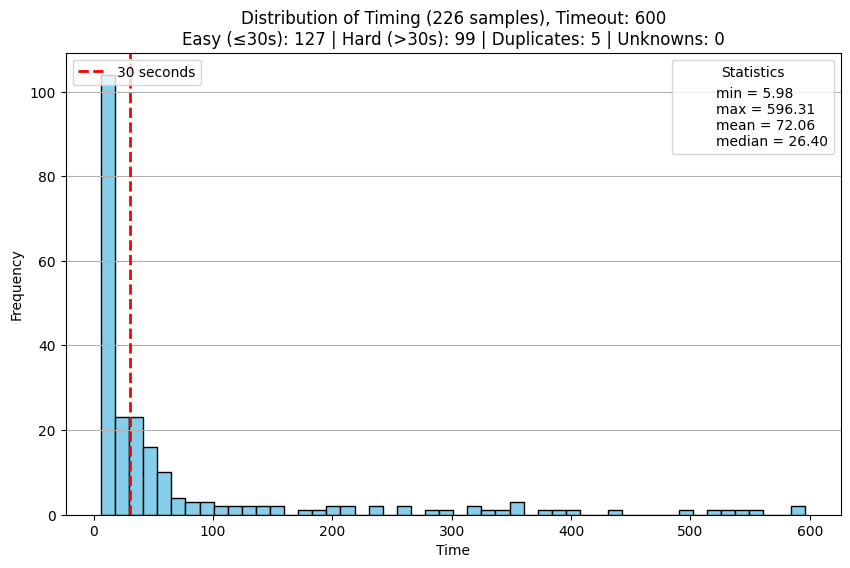

In [56]:
plot_timing_distribution(original_timing_df)

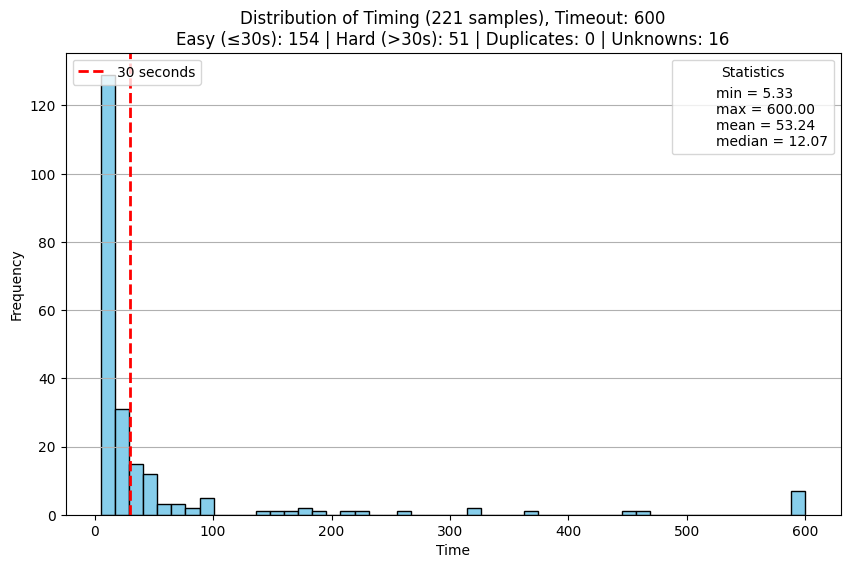

In [57]:
plot_timing_distribution(new_df)

16 samples with 'UNKNOWN' result


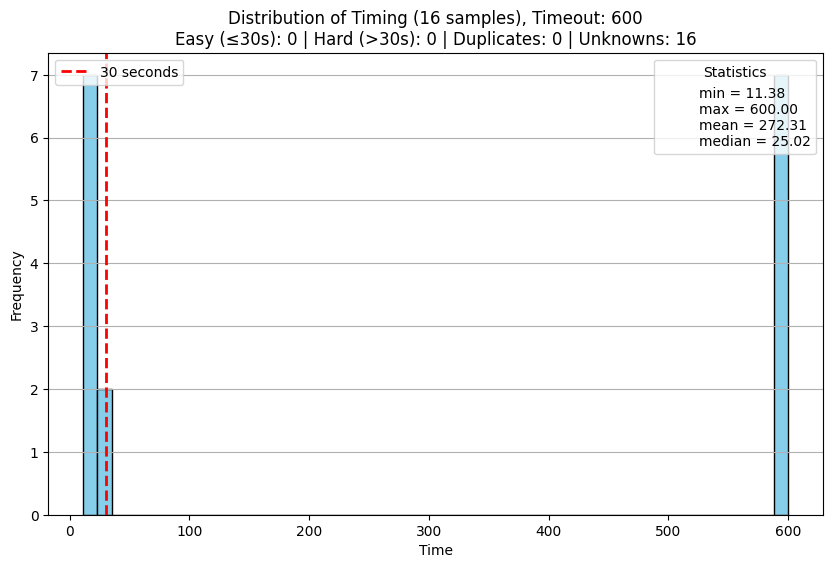

In [58]:
# Plot timing distribution for the "Unknown" results in new_df

unknown_df = new_df[new_df['result'] == 'UNKNOWN']

if not unknown_df.empty:
    print(f"{len(unknown_df)} samples with 'UNKNOWN' result")
    plot_timing_distribution(unknown_df)
else:
    print("No samples with 'UNKNOWN' result found in new_df.")


In [ ]:
# df without unknown results
df_no_unknown = new_df[new_df['result'] != 'UNKNOWN']

# easy df without unknown results
easy_df_no_unknown = df_no_unknown[df_no_unknown['time'] <= 30]

# hard df without unknown results
hard_df_no_unknown = df_no_unknown[df_no_unknown['time'] > 30]

# unknown df


In [ ]:
unknown_df = new_df[new_df['result'] == 'UNKNOWN']
# save the unknown df as a csv file
unknown_df.to_csv('dataset/evaluation/unknowns/unknown_timing.csv', index=False)
# save the unknown df as a json file
unknown_df.to_json('dataset/evaluation/unknowns/unknown_timing.json', orient='records')

In [98]:
# save the easy and hard dataframes as csv files
easy_df_no_unknown.to_csv('dataset/evaluation/easy/easy_timing.csv', index=False)
hard_df_no_unknown.to_csv('dataset/evaluation/hard/hard_timing.csv', index=False)
# save the easy and hard dataframes as json files
easy_df_no_unknown.to_json('dataset/evaluation/easy/easy_timing.json', orient='records')
hard_df_no_unknown.to_json('dataset/evaluation/hard/hard_timing.json', orient='records')


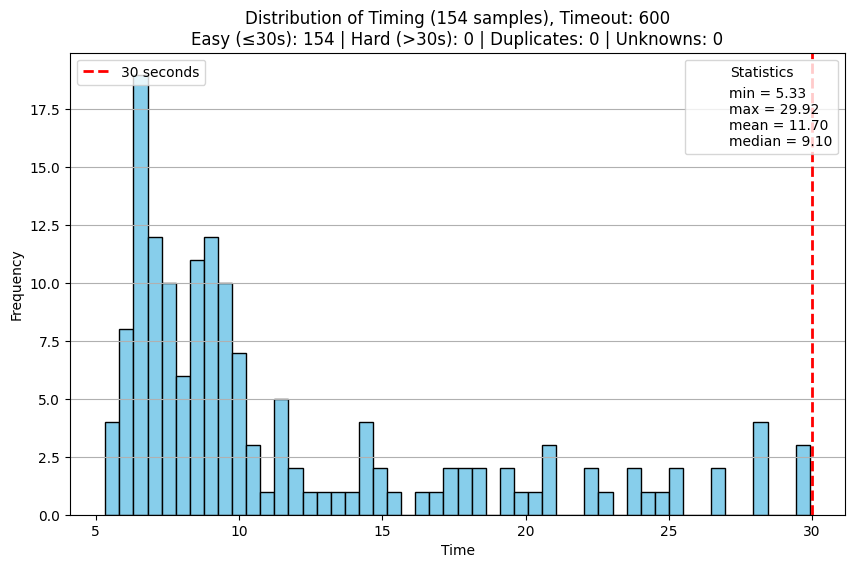

In [60]:
plot_timing_distribution(easy_df_no_unknown)

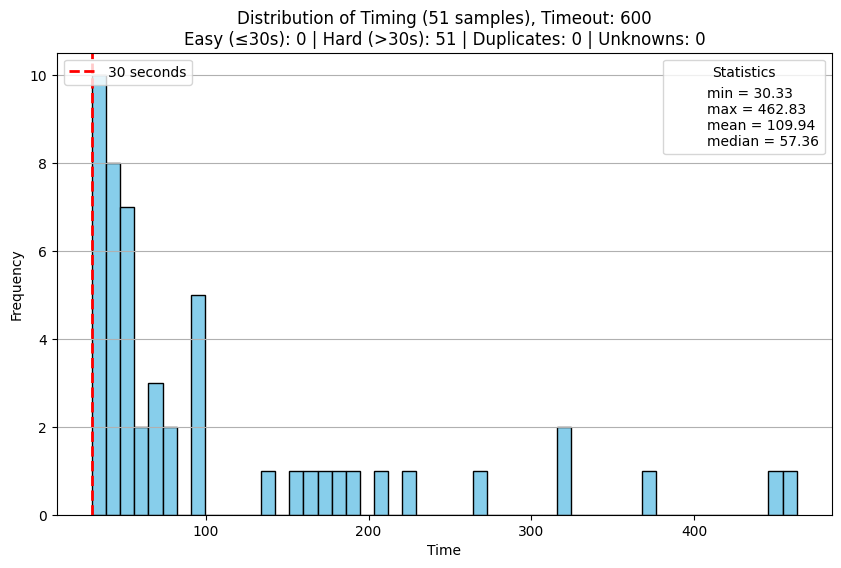

In [61]:
plot_timing_distribution(hard_df_no_unknown)

In [ ]:
# Check if every result from df_no_unknown is equal to the result from original_timing_df

# Let's assume both dataframes can be joined on the 'file' column.
# We'll merge the two dataframes and compare the 'result' columns.

merged_df = df_no_unknown.merge(original_timing_df, left_on='file', right_on='file', suffixes=('_new', '_orig'))

comparison = merged_df['result_new'] == merged_df['result_orig']

if comparison.all():
    print("All results from df_no_unknown match those in original_timing_df.")
else:
    mismatch_count = (~comparison).sum()
    print(f"{mismatch_count} mismatches found between df_no_unknown and original_timing_df.")
    print(merged_df.loc[~comparison, ['file', 'result_new', 'result_orig']])


All results from df_no_unknown match those in original_timing_df.


In [ ]:
unknown_df = new_df[new_df['result'] == 'UNKNOWN']
unknown_df.head(16)

,file,result,time
4,dll-queue-1_4,UNKNOWN,11.376340
15,sll-queue-1_12,UNKNOWN,21.802832
25,sll-01-1_9,UNKNOWN,18.236488
77,dll-rb-cnstr_1-2_4,UNKNOWN,14.729256
79,dll-simple-white-blue-2_2,UNKNOWN,600.000000
84,sll-01-1_8,UNKNOWN,11.684269
92,dll-rb-cnstr_1-2_3,UNKNOWN,14.517776
103,dijkstra-u_valuebound20_8,UNKNOWN,600.000000
113,sll-01-2_9,UNKNOWN,14.498334
115,hard2_4,UNKNOWN,600.000000


In [71]:
# what was the time of sll-queue-1_12 in the original dataframe?
original_timing_df[original_timing_df['file'] == 'sll-queue-1_12.c']

,result,file,time
215,TRUE,sll-queue-1_12.c,6.649688


,file,result,time
0,freire2_unwindbound1_4,TRUE,211.832668
1,prod4br-ll_valuebound10_1,TRUE,8.817179
2,hard-u_unwindbound1_5,TRUE,5.809765
3,geo3-ll_unwindbound1_2,TRUE,43.848031
4,dll-queue-1_4,UNKNOWN,11.376340
5,bresenham-ll_unwindbound10_2,FALSE,321.735113
6,hard2_valuebound2_5,TRUE,22.726662
7,cohencu-ll_valuebound5_9,TRUE,34.422477
8,egcd3-ll_unwindbound10_3,TRUE,12.186901
9,fermat1-ll_unwindbound10_4,FALSE,168.263132


In [77]:
# Count how many problems changed from TRUE/FALSE in original_timing_df to UNKNOWN in new_df
# Normalize filenames: remove .c extension from original_timing_df to match new_df
original_timing_df_normalized = original_timing_df.copy()
original_timing_df_normalized['file'] = original_timing_df_normalized['file'].str.replace('.c', '', regex=False)

# Merge original and new dataframes on 'file' to compare results side by side
merged = original_timing_df_normalized.merge(new_df[['file', 'result']], on='file', how='inner', suffixes=('_orig', '_new'))

# TRUE -> UNKNOWN
true_to_unknown = ((merged['result_orig'] == 'TRUE') & (merged['result_new'] == 'UNKNOWN')).sum()
# FALSE -> UNKNOWN
false_to_unknown = ((merged['result_orig'] == 'FALSE') & (merged['result_new'] == 'UNKNOWN')).sum()

print(f"Number of problems that went from TRUE to UNKNOWN: {true_to_unknown}")
print(f"Number of problems that went from FALSE to UNKNOWN: {false_to_unknown}")

Number of problems that went from TRUE to UNKNOWN: 14
Number of problems that went from FALSE to UNKNOWN: 2


In [92]:
# Get the filenames that went from FALSE to UNKNOWN and their timing
false_to_unknown_files = merged.loc[
    (merged['result_orig'] == 'FALSE') & (merged['result_new'] == 'UNKNOWN'), 'file'
]
print("\nFilenames that went from FALSE to UNKNOWN:")
print(false_to_unknown_files.tolist())
# Get the timing of the files that went from FALSE to UNKNOWN
false_to_unknown_timing = merged.loc[
    (merged['result_orig'] == 'FALSE') & (merged['result_new'] == 'UNKNOWN'), 'time'
]
print("\nTiming of files that went from FALSE to UNKNOWN:")
print(false_to_unknown_timing.tolist())




Filenames that went from FALSE to UNKNOWN:
['eureka_01-1_1', 'hard-u_5']

Timing of files that went from FALSE to UNKNOWN:
[437.2881145477295, 493.7748918533325]


In [ ]:
# save 

,result_orig,file,time,result_new
